### Contents

1. [Чтение данных](#чтение-данных)
2. [Что видно невооруженным глазом](#что-видно-невооруженным-глазом)  
    Разглядывание данных под разными углами, распределение цен, частоты, даты заказов,  
    промежутков времени между заказами по группам клиентов
3. [Time series perspective](#time-series-perspective)  
    ...и гипотеза о пуассоновском потоке
4. [Retention](#retention)  
    Выводы и вычисление

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-darkgrid')

### Чтение данных
[[To the top]](#contents)

Сразу добавлю несколько производных признаков с говорящими именами, комментарии по ним ниже

In [3]:
df = (
    pd.read_excel('data/test_data_1.xlsx',
                   parse_dates=['order_date'])
    .pipe(lambda df: df
          .sort_values('order_date')
          .assign(
              order_cumcount = (
                  df
                  .groupby('client_id')
                  .cumcount()
                  ),
              price_cumsum = (
                  df
                  .groupby('client_id')['order_price']
                  .cumsum()
                  ),
              days_since_last_order = ( 
                  df
                  .groupby('client_id')['order_date']
                  .diff())
    ))
    # few more separate pipes follow 
    # since newly assigned/transformed columns won't be visible otherwise
    .pipe(lambda df: df 
          .assign(
              n_orders = ( 
                  df
                  .groupby('client_id')['order_cumcount']
                  .transform('max')
                  .apply(lambda x: x+1)
            ),
            days_since_last_order = df.days_since_last_order.dt.days,
    ))
    .pipe(lambda df: df
          .assign(
              more_than_one_order = df.n_orders>1,
              order_month = df.order_date.dt.month,
              order_day = df.order_date.dt.day,
              order_weekday = df.order_date.dt.weekday,
              days_since_last_order = df.days_since_last_order.fillna(-1),
              is_first_time = df.order_cumcount==0,
        )
          .astype({
              'more_than_one_order': int,
              'is_first_time': int,
        }))
)

Пару примеров для иллюстрации: первый -- для клиента с тремя заказами, второй - с одним

In [123]:
df.loc[df.client_id==50198]

,client_id,order_date,order_price,city_id,order_cumcount,price_cumsum,days_since_last_order,n_orders,more_than_one_order,order_month,order_day,order_weekday,is_first_time
8163,50198,2022-08-24,8200,3,0,8200,-1.0,3,1,8,24,2,1
8164,50198,2022-09-05,2500,3,1,10700,12.0,3,1,9,5,0,0
8165,50198,2022-10-28,8350,3,2,19050,53.0,3,1,10,28,4,0


In [124]:
df.loc[df.client_id==43383]

,client_id,order_date,order_price,city_id,order_cumcount,price_cumsum,days_since_last_order,n_orders,more_than_one_order,order_month,order_day,order_weekday,is_first_time
523,43383,2022-01-01,9650,1,0,9650,-1.0,1,0,1,1,5,1


### Что видно невооруженным глазом
[[To the top]](#contents)

In [142]:
(
    df
    .client_id
    .value_counts()
    .sort_values()
)

client_id
49698    1
49331    1
43743    1
49240    1
49102    1
        ..
48147    3
48410    3
46263    3
46606    3
46788    3
Name: count, Length: 8925, dtype: int64

In [141]:
( 
    df
    .groupby('client_id')['order_date']
    .count()
    .value_counts()
    .apply(lambda x: f'{x/df.client_id.unique().shape[0]:.2f}')
)

order_date
1    0.81
2    0.15
3    0.04
Name: count, dtype: object

Уникальных клиентов - 8925, из них совершили один, два и три заказа 81%, 15% и 4% соответственно. 

In [143]:
df.order_date.dt.year.value_counts()

order_date
2022    10926
Name: count, dtype: int64

In [145]:
(
    df
    .order_date
    .dt.month
    .value_counts()
    .sort_index()
)

order_date
1     1084
2     1141
3     1234
4     1166
5     1093
6     1035
7     1061
8     1064
9     1014
10    1034
Name: count, dtype: int64

Все данные умещаются в 10 месяцев 2022 года. Посмотрим на динамику заказов

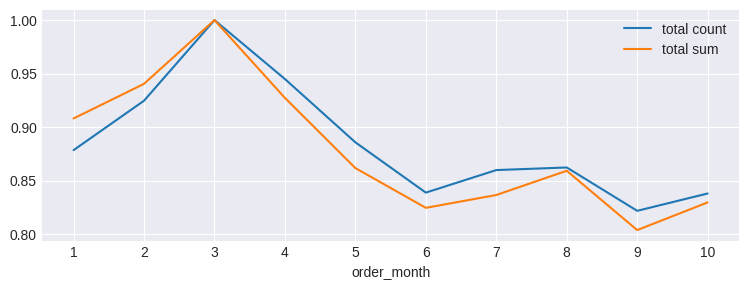

In [146]:
fig,ax=plt.subplots(figsize=(9,3))

by_month = df.groupby('order_month')['order_price']

max_count = ( 
    by_month
    .count()
    .max()
)
max_sum = ( 
    by_month
    .sum()
    .max()
)

( 
    by_month
    .count()
    .apply(lambda x: x/max_count)
    .plot(kind='line', 
       ax=ax,
       xticks=np.arange(1,11))
)
( 
    by_month
    .sum()
    .apply(lambda x: x/max_sum)
    .plot(kind='line', 
       ax=ax,
       xticks=np.arange(1,11))
)
ax.legend(['total count', 'total sum']);

Для удобства графики приведены к одному масштабу.
Отчетливый рост с пиком в марте, дальше заказы - как по числу, так и по суммарной стоимости - идут на спад в немного осциллирующей манере.

Объясняется ли пик сезональностью на уровне года сказать нельзя, нужно смотреть другие года.

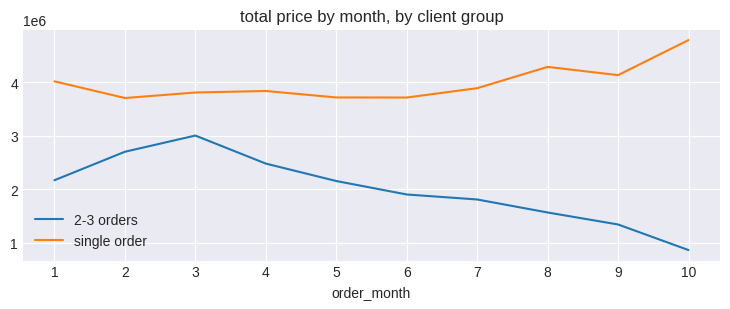

In [148]:
fig,ax=plt.subplots(figsize=(9,3))
ax.set_title('total price by month, by client group')

for mask in [df.n_orders>1, df.n_orders==1]: 
    ( 
        df
        .loc[mask]
        .groupby('order_month')
        ['order_price']
        .sum()
        .plot(kind='line',
              ax=ax,
              xticks=np.arange(1,11))
    )
ax.legend(['2-3 orders', 'single order']);

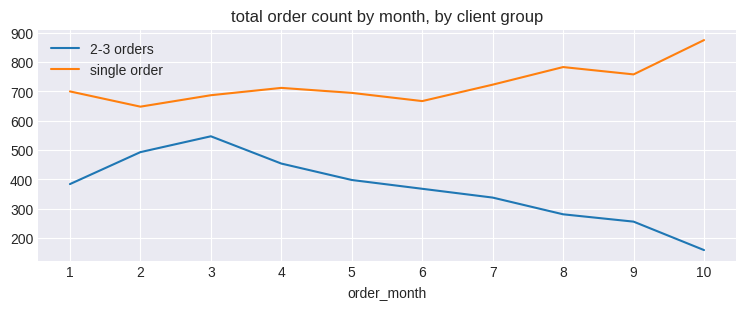

In [152]:
fig,ax=plt.subplots(figsize=(9,3))
ax.set_title('total order count by month, by client group')

for mask in [df.n_orders>1, df.n_orders==1]: 
    ( 
        df
        .loc[mask]
        .groupby('order_month')
        ['order_price']
        .count()
        .plot(kind='line',
              ax=ax,
              xticks=np.arange(1,11))
    )
ax.legend(['2-3 orders', 'single order']);

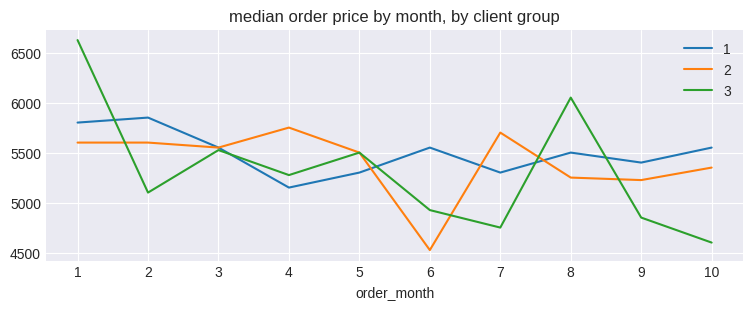

In [160]:
fig,ax=plt.subplots(figsize=(9,3))
ax.set_title('median order price by month, by client group')

for order_cnt in [1,2,3]:
    ( 
        df
        .loc[df.n_orders==order_cnt]
        .groupby('order_month')
        ['order_price']
        .median()
        .plot(kind='line', 
        ax=ax,
        xticks=np.arange(1,11))
    )
ax.legend(range(1,4));

Частые клиенты (2-3 заказа) обеспечивали основной рост до мартовского пика, затем их вклад стал монотонно уменьшаться, а "разовых" клиентов - расти. Что наводит на вопрос о важности первых и важности ретеншена как метрики (на данном этапе развития компании и в данных рыночных условиях).

Посмотрим на распределение цен заказов для разных классов клиентов. Можно предположить, что непостоянные покупатели ищут мгновенной выгоды и выходят на охоту только во время распродаж, отдельных акций и тд, т.е. обитают в более низком ценовом сегменте.  

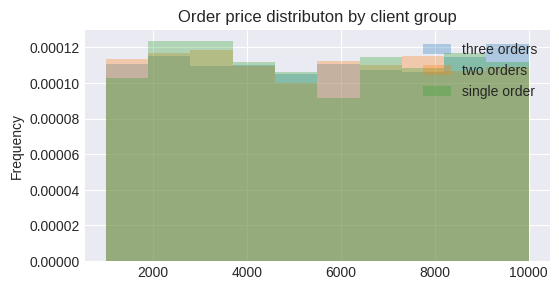

In [155]:
fig,ax=plt.subplots(figsize=(6,3))

for order_cnt in [1,2,3]:
    (
        df
        .loc[df.n_orders==order_cnt, 'order_price']
        .plot(
            kind='hist',
            ax=ax,
            alpha=0.3,
            density=True
        )
    )
ax.set_title('Order price distributon by client group')
ax.legend(['three orders', 'two orders', 'single order']);

Как ни странно, распределение очень равномерное и без хвостов (возможно, кто-то использовал равномерное распределение для генерации данных, но это не точно).

Посмотрим, что вообще отличает частых клиентов от нечастых (if any).

Может быть, география?

In [165]:
pd.crosstab(df.n_orders, df.city_id)

city_id,1,2,3
n_orders,,,
1,2434,2398,2416
2,854,936,916
3,339,330,303


По городам распределение тоже в целом равномерное 

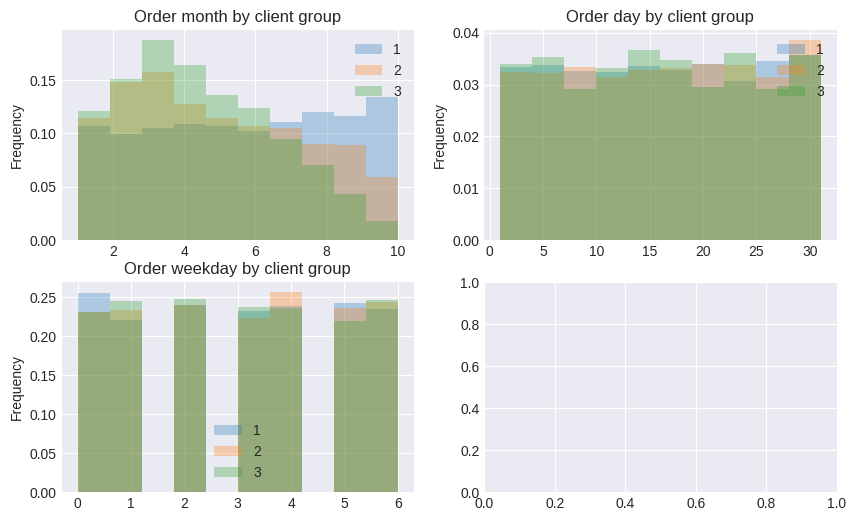

In [85]:
fig,ax=plt.subplots(2,2, figsize=(10,6))
for order_cnt in [1,2,3]:
    (
        df
        .loc[df.n_orders==order_cnt]
        .order_date.dt.month
        .plot(
            kind='hist',
            ax=ax[0][0],
            density=True,
            alpha=0.3,
            title='Order month by client group'
        )
    )
ax[0][0].legend(range(1,4));

for order_cnt in [1,2,3]:
    (
        df
        .loc[df.n_orders==order_cnt]
        .order_date.dt.day
        .plot(
            kind='hist',
            ax=ax[0][1],
            density=True,
            alpha=0.3,
            title='Order day by client group'
        )
    )
ax[0][1].legend(range(1,4));

for order_cnt in [1,2,3]:
    (
        df
        .loc[df.n_orders==order_cnt]
        .order_date.dt.weekday
        .plot(
            kind='hist',
            ax=ax[1][0],
            density=True,
            alpha=0.3,
            title='Order weekday by client group'
        )
    )
ax[1][0].legend(range(1,4));

Частые клиенты были более активны в первой половине года (левый-верхний график), в остальном отличий не видно.

Посмотрим сколько времени разделяет смежные заказы частых клиентов.

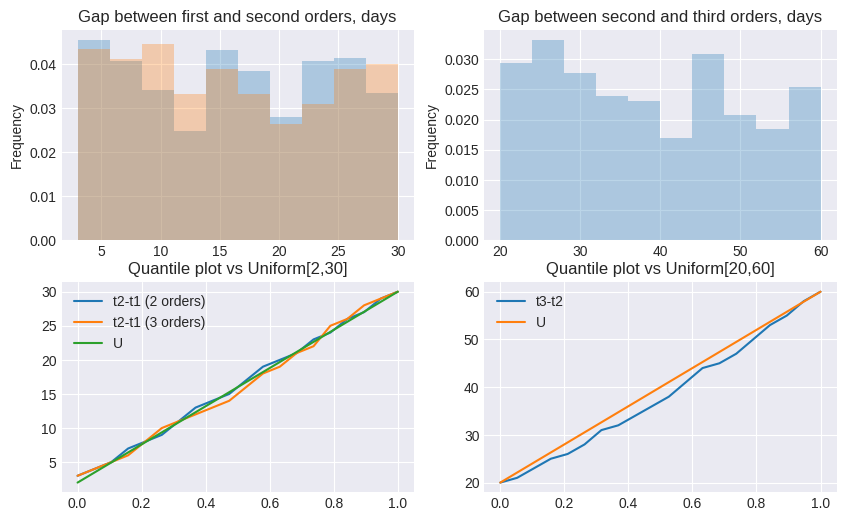

In [299]:
fig,ax=plt.subplots(2,2, figsize=(10,6))
ax[0][0].set_title('Gap between first and second orders, days')
ax[0][1].set_title('Gap between second and third orders, days')
ax[1][0].set_title('Quantile plot vs Uniform[2,30]')
ax[1][1].set_title('Quantile plot vs Uniform[20,60]')

tmp = lambda cnt: (
        df
        .loc[df.n_orders==cnt]
        .groupby('client_id')
        ['order_date']
)
cnts2 = tmp(2).agg(lambda s: (s.iloc[1] - s.iloc[0]).days)
cnts3 = tmp(3).agg(lambda s: (s.iloc[1] - s.iloc[0]).days)
cnts4 = tmp(3).agg(lambda s: (s.iloc[2] - s.iloc[1]).days) 

plot_hist = lambda s, ax: s.plot(kind='hist',alpha=0.3,ax=ax,density=True)

plot_hist(cnts2, ax[0][0])
plot_hist(cnts3, ax[0][0])
plot_hist(cnts4, ax[0][1])

quantiles = np.linspace(0,1, 20)

q2 = np.quantile(cnts2.values, quantiles)
q3 = np.quantile(cnts3.values, quantiles)
q4 = np.quantile(cnts4.values, quantiles)

ax[1][0].plot(quantiles, q2)
ax[1][0].plot(quantiles, q3)
ax[1][0].plot([0,1], [2,30])
ax[1][0].legend(['t2-t1 (2 orders)', 't2-t1 (3 orders)', 'U']);

ax[1][1].plot(quantiles, q4)
ax[1][1].plot([0,1], [20,60])
ax[1][1].legend(['t3-t2', 'U']);

Таким образом, вероятность второго заказа равновероятна в пределах месяца от первого. Вероятность третьего - *приблизительно* равновероятна в пределах *двух* месяцев от второго (масса распределения сдвинута в сторону более малых значений, чем равномерное).

Из этой картины можно извлечь следующую оценку: после первого месяца "молчания" с первого заказа вероятность резко падает (возможно, сгорают баллы, оставшиеся с первого заказа или нечто в этом роде).

Для тех, кто совершил два заказа, зависимость ослабляется: нужно выждать уже два месяца, чтобы иметь некоторую уверенность.

### Time series perspective
[[To the top]](#contents)

Посмотрим ближе на временной ряд цен заказов

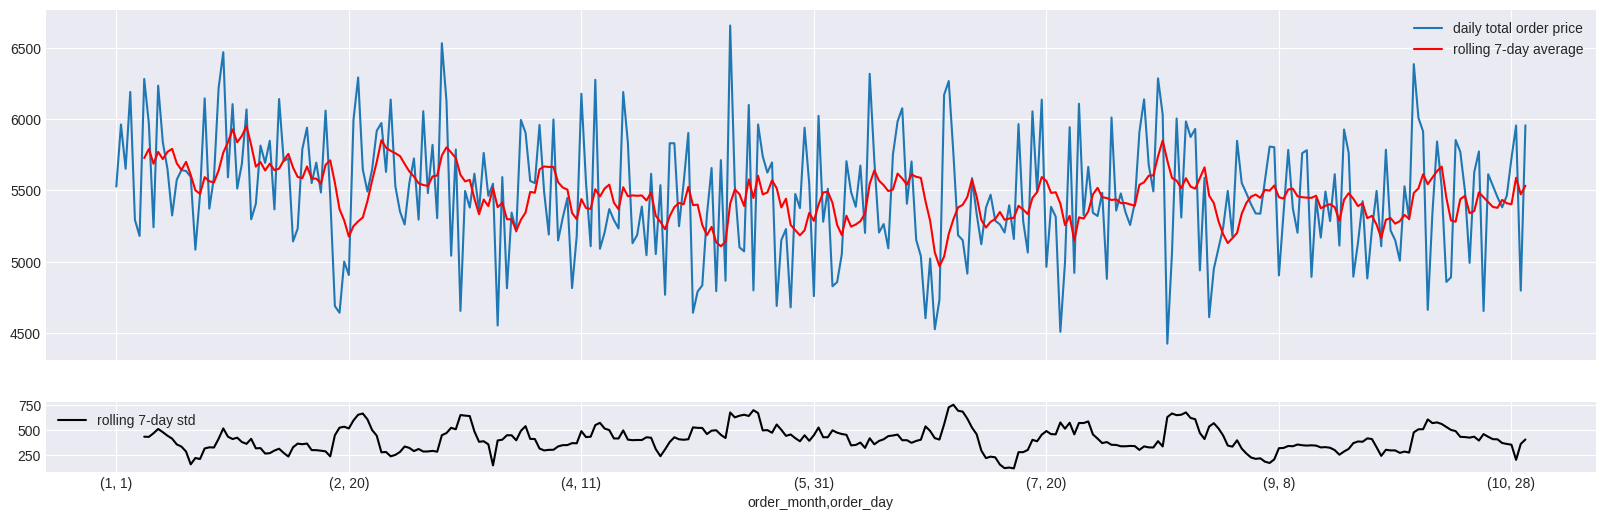

In [281]:
fig,ax=plt.subplots(2,1,
                    figsize=(20,6),
                    sharex=True,
                    gridspec_kw={'height_ratios': [5, 1]})

daily = (
    df
    .groupby(['order_month','order_day'])
    ['order_price']
    .mean()
)
daily.plot(kind='line',ax=ax[0])
smooth = 7
(
    daily
    .rolling(smooth)
    .mean()
    .plot(kind='line',ax=ax[0],c='r')
)
(
    daily
    .rolling(smooth)
    .std()
    .plot(kind='line',ax=ax[1],c='k')
)
ax[0].legend(['daily total order price', f'rolling {smooth}-day average'])
ax[1].legend([f'rolling {smooth}-day std']);

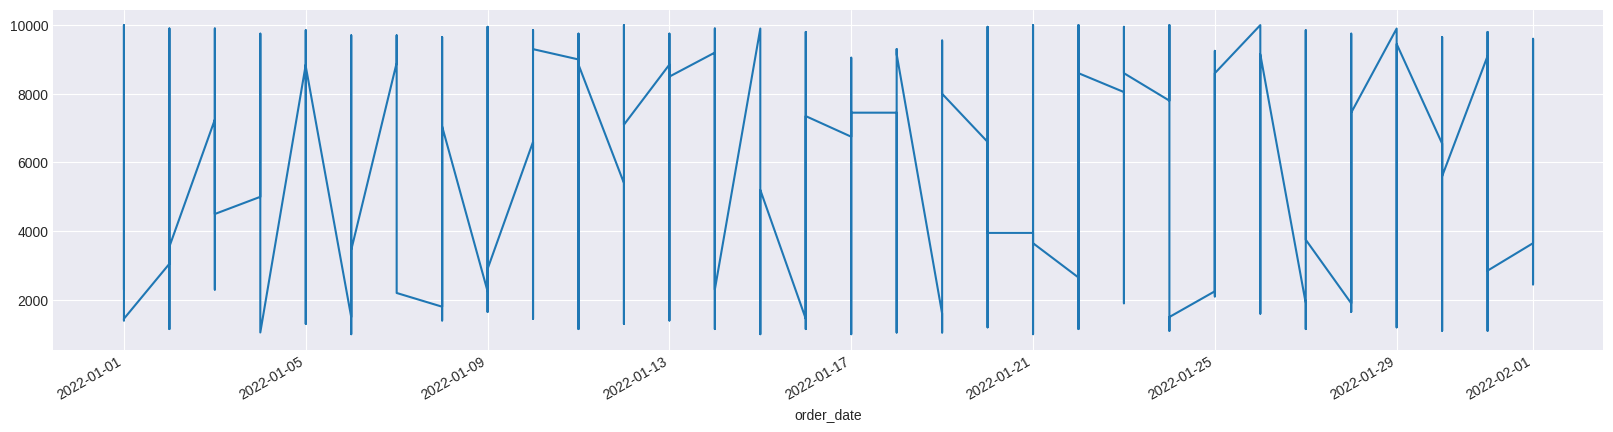

In [228]:
fig,ax=plt.subplots(figsize=(20,5))
(
    df
    .set_index('order_date')
    .loc[:'2022-02-01']
    .order_price
    .plot(kind='line',ax=ax)
);

Если исходный ряд не агрегировать вовсе и приблизить, то видно, что это равномерное распределение или нечто близко-производное

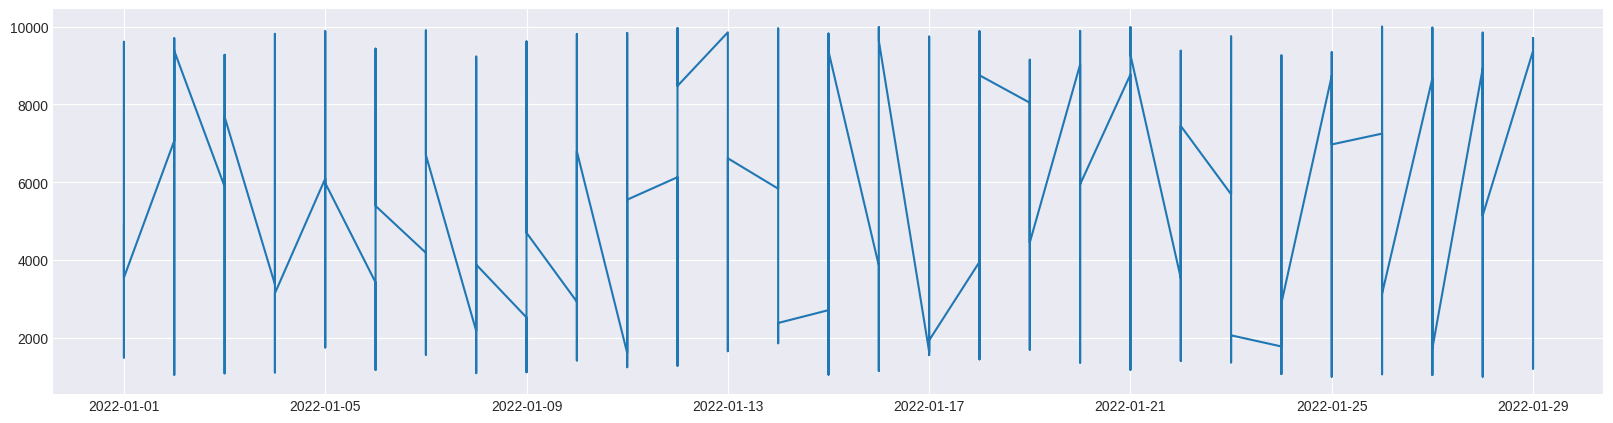

In [ ]:
fig,ax=plt.subplots(figsize=(20,5))
u = np.random.rand(1000)*9000+1000
ax.plot(df.order_date.iloc[:1000], u);

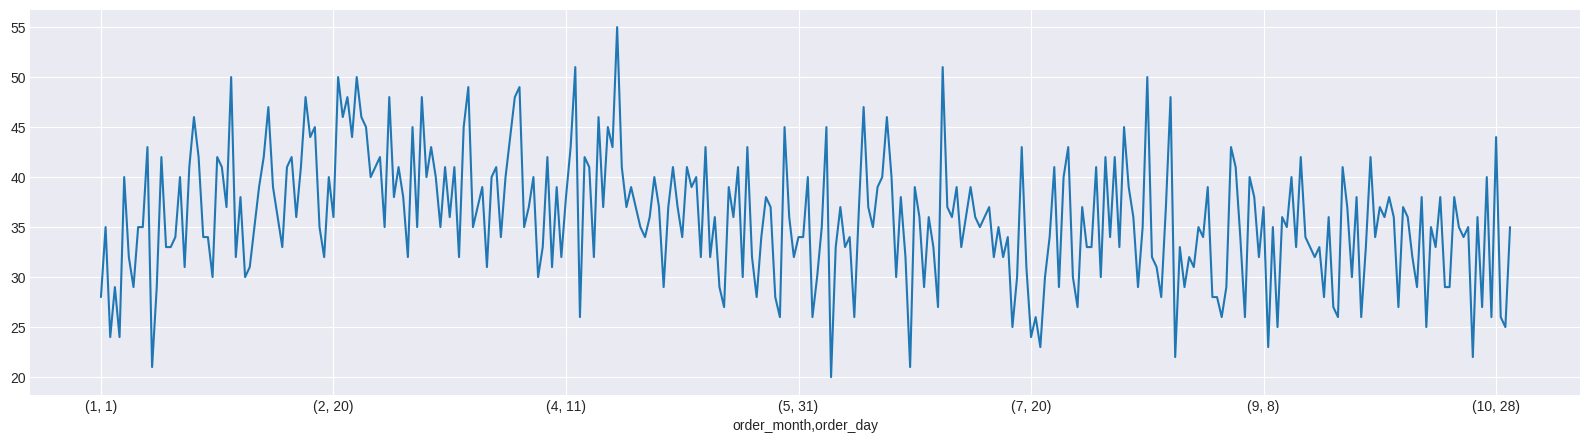

In [257]:
fig,ax=plt.subplots(figsize=(20,5))
( 
    df
    .groupby(['order_month','order_day'])
    ['order_price']
    .count()
    .plot(kind='line',ax=ax)
);

Число заказов в день явно не равномерное. Смотрим гистограмму

In [26]:
cnt = ( 
    df
    .groupby(['order_month','order_day'])
    ['order_price']
    .count()
);

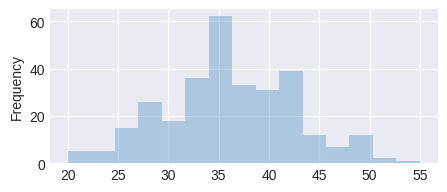

In [262]:
fig,ax=plt.subplots(figsize=(5,2))
cnt.plot(kind='hist',ax=ax, alpha=0.3, bins=15);

По облику и по смыслу (простой поток событий) подходит Пуассон с лямбдой примерно 35.
После пары симуляций больше похоже на 36. Квантильные графики почти совпадают. 

np.float64(35.94078947368421)

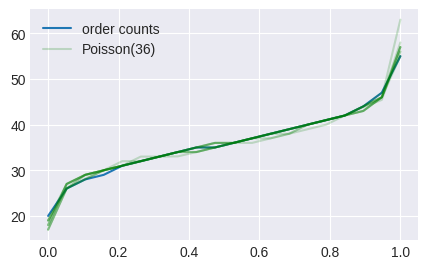

In [27]:
quantiles = np.linspace(0,1, 20)
q1 = np.quantile(cnt.values, quantiles)
poiss_lambda = 36
q2 = np.quantile(np.random.poisson(poiss_lambda, size=(10,1000)), quantiles, axis=1)

fig,ax = plt.subplots(figsize=(5,3))
ax.plot(quantiles, q1)
ax.plot(quantiles, q2, alpha=0.2, c='g')
ax.legend(['order counts', f'Poisson({poiss_lambda})']);

cnt.mean()

### Retention
[[To the top]](#contents)

Из набросков выше складывается следующая картина: 
1. Число заказов в день похоже на пуассоновский поток с интенсивностью 36
2. Цена заказов распределена примерно равномерно между 1000 и 10000
3. Клиенты совершают максимум три заказа и держатся максимум три месяца
4. Второй заказ совершают в пределах месяца от первого, либо уходят
5. Третий заказ совершают в пределах двух месяцев от второго, либо уходят

Значит, для оценки числа оставшихся клиентов имеет смысл рассматривать окно в три последних месяца. 
Из общего числа клиентов в этот период вычитаем тех, кто не совершил очередной заказ в ожидаемое время (месяц для первых клиентов, два месяца для "вторых", и "третьих" независимо от времени).

Ретеншен обычно определен как соотношение числа *старых* клиентов на конец периода к числу клиентов на начало периода.
В качестве периода возьмем месяц, но можно рассчитать и для других периодов.

In [ ]:
def estim_clients_to_stay(df, month):
    def count(df,start,end,filt): 
        return ( 
            df
            .set_index('order_date')
            .loc[start:end]
            .pipe(filt)
            .groupby('client_id')
            .count().shape[0]
        )

    # all clients who made orders during last three months
    total = count(df, f'2022-{month-3}',f'2022-{month-1}',
                  lambda df:df)
    # 3rd-orders' are gone for good
    gone_3rd = count(df, f'2022-{month-3}',f'2022-{month-1}',
                     lambda df: df.loc[df.n_orders==3])
    # 2nd-orders who made their second order 2 months ago are gone
    gone_2nd = count(df, f'2022-{month-3}',f'2022-{month-3}',
                     lambda df: df.loc[(df.n_orders==2) & (df.order_cumcount==1)])
    # first-orders' who made their order month or more ago are gone
    gone_1st = count(df, f'2022-{month-3}',f'2022-{month-2}',
                     lambda df: df.loc[(df.n_orders==1)])
    return total - gone_3rd - gone_2nd - gone_1st
    
def retention(df, month):
    start_cnt = estim_clients_to_stay(df, month)
    end_cnt = estim_clients_to_stay(df, month+1)
    new_cnt = ( 
        df
        .set_index('order_date')
        .loc[f'2022-{month}']
        .pipe(lambda df: df.loc[(df.n_orders==1)])
        .groupby('client_id')
        .count().shape[0]
    )
    return (end_cnt - new_cnt)/start_cnt

In [84]:
pd.DataFrame({'ret': [f'{retention(df, m):.2f}' for m in range(4,11)],
              'month': range(4,11)})

,ret,month
0,0.38,4
1,0.33,5
2,0.32,6
3,0.32,7
4,0.29,8
5,0.25,9
6,0.21,10


Таким образом, если принять допущения выше об оттоке клиентской базы, получаем монотонно убывающий ретеншен. 
Отдельный вопрос -- какой из этого сделать вывод. Выше отмечалось, что частые клиенты обитают в том же ценовом сегменте, что и разовые клиенты. Общее (среднее) число заказов не зависит от их числа. Так что популярная гипотеза о высокой ценности частых клиентов здесь не подтверждается и ретеншен нужно отслеживать вместе с другими метриками.